## Feature Selection

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, RFE, SelectFromModel, chi2
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler


In [75]:
def correlationSelection(X, y, featureList, LabelColumnName, dataset, featureNumber):
    # Compute the correlation matrix
    corrmat = dataset.corr()
    
    # Dynamically calculate the index for the target column in the correlation matrix
    target_index = corrmat.columns.get_loc(LabelColumnName)
    
    # Correlation of features with the target column
    corr_ = corrmat.iloc[target_index, :]
    corr_scores = corr_.tolist()
    
    # Combine features and their correlation scores
    unsorted_scores = list(zip(featureList, corr_scores))
    featureScoreDataFrame = pd.DataFrame(unsorted_scores, columns=['Feature', 'score']).sort_values(by='score', ascending=False)
    
    # Select top features
    featureNumber = featureNumber + 1  # Including the label
    selectedFeature = featureScoreDataFrame.head(featureNumber).sort_values(by='score')['Feature'].tolist()
    seriesFeature = pd.Series(featureScoreDataFrame['score'].values, featureScoreDataFrame['Feature'].values)
    
    # Plot the top features by correlation
    plt.figure(figsize=(16, 16))
    seriesFeature.nlargest(77).plot(kind='barh')
    plt.show()
    
    # Return the selected features
    featureDataFrame = dataset.loc[:, selectedFeature]
    return featureDataFrame


In [3]:
def univariateSelection(X,y,featureList,LabelColumnName,dataset,featureNumber):#this method selects the feature with Anova-F
    model=SelectKBest(k = 'all')
    model.fit(X,y)
    unsorted_scores = list(zip(featureList[1:], model.scores_))
    featureScoreDataFrame=pd.DataFrame(unsorted_scores, columns = ['Feature', 'score']).sort_values(by = 'score', ascending = False)
    selectedFeature=featureScoreDataFrame.head(featureNumber)['Feature'].tolist() + [LabelColumnName]
    featureDataFrame=dataset.loc[:,selectedFeature]
    seriesFeature=pd.Series(featureScoreDataFrame['score'].values, featureScoreDataFrame['Feature'].values)
    plt.figure(figsize=(16,16))
    seriesFeature.nlargest(77).plot(kind='barh')
    plt.show()
    return featureScoreDataFrame,featureDataFrame

In [4]:
def randomForestSelection(X,y,featureList,LabelColumnName,dataset, featureNumber):#this method selects the feature with random forest
    model=RandomForestClassifier(n_estimators=20)
    model.fit(X,y)
    importances = list(model.feature_importances_)
    featureImportances = [(feature, round(importance, 4)) for feature, importance in zip(featureList, importances)]
    featureImportances= sorted(featureImportances, key = lambda x: x[1], reverse = True)
    unsorted_scores = list(zip(featureList, model.feature_importances_))
    featureScoreDataFrame=pd.DataFrame(unsorted_scores, columns = ['Feature', 'score']).sort_values(by = 'score', ascending = False)
    selectedFeature=featureScoreDataFrame.head(featureNumber)['Feature'].tolist() + [LabelColumnName]
    featureDataFrame=dataset.loc[:,selectedFeature]
    seriesFeature=pd.Series(model.feature_importances_, index=dataset.drop([LabelColumnName],axis=1).columns)
    plt.figure(figsize=(16,16))
    seriesFeature.nlargest(77).plot(kind='barh')
    plt.show()
    return featureScoreDataFrame,featureDataFrame

In [5]:
def extraTreesSelection(X,y,featureList,LabelColumnName,dataset,featureNumber): #this method selects the feature with Extra Trees
    model=ExtraTreesClassifier(n_estimators=250,random_state=0)
    model.fit(X,y)
    seriesFeature=pd.Series(model.feature_importances_, index=featureList)
    plt.figure(figsize=(16,16))
    seriesFeature.nlargest(77).plot(kind='barh')
    plt.show()
    unsorted_scores = list(zip(featureList, model.feature_importances_))
    featureScoreDataFrame=pd.DataFrame(unsorted_scores, columns = ['Feature', 'score']).sort_values(by = 'score', ascending = False)
    selectedFeature=featureScoreDataFrame.head(featureNumber)['Feature'].tolist() + [LabelColumnName]
    featureDataFrame=dataset.loc[:,selectedFeature]
    return featureScoreDataFrame,featureDataFrame

In [6]:
def lassoSelection(X, y, featureList, LabelColumnName, dataset, featureNumber, alpha=0.01):
    # Fit Lasso model
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    
    # Get feature importances (coefficients)
    model = SelectFromModel(lasso, prefit=True, max_features=featureNumber)
    selected_features = model.get_support(indices=True)
    
    # Create DataFrame for feature scores
    feature_scores = abs(lasso.coef_)
    unsorted_scores = list(zip(featureList, feature_scores))
    featureScoreDataFrame = pd.DataFrame(unsorted_scores, columns=['Feature', 'score']).sort_values(by='score', ascending=False)
    
    selectedFeature = featureScoreDataFrame.head(featureNumber)['Feature'].tolist() + [LabelColumnName]
    featureDataFrame = dataset.loc[:, selectedFeature]
    
    # Plot feature importances
    seriesFeature = pd.Series(feature_scores, index=featureList)
    plt.figure(figsize=(16, 16))
    seriesFeature.nlargest(featureNumber).plot(kind='barh')
    plt.title('Feature Importance using Lasso')
    plt.show()
    
    return featureScoreDataFrame, featureDataFrame

In [13]:
def votingSystem(correlation_df, univariate_df, random_forest_df, extra_trees_df, lasso_df):
    # Initialize a DataFrame to track votes
    all_features = list(set(correlation_df['Feature']).union(univariate_df['Feature'], 
                                                             random_forest_df['Feature'], 
                                                             extra_trees_df['Feature'],
                                                             lasso_df['Feature']))
    
    votes_df = pd.DataFrame(0, index=all_features, columns=['Correlation', 'Univariate', 'RandomForest', 'ExtraTrees', 'Lasso'])
    
    # Add votes
    for feature in correlation_df['Feature']:
        votes_df.loc[feature, 'Correlation'] += 1
    for feature in univariate_df['Feature']:
        votes_df.loc[feature, 'Univariate'] += 1
    for feature in random_forest_df['Feature']:
        votes_df.loc[feature, 'RandomForest'] += 1
    for feature in extra_trees_df['Feature']:
        votes_df.loc[feature, 'ExtraTrees'] += 1
    for feature in lasso_df['Feature']:
        votes_df.loc[feature, 'Lasso'] += 1
    
    # Sum total votes
    votes_df['Total Votes'] = votes_df.sum(axis=1)
    votes_df = votes_df.sort_values('Total Votes', ascending=False)
    
    return votes_df


In [3]:
dataset = pd.read_csv("processed_data/data1.csv")
dataset.head()

Destination Port  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0                80          32893                  1                       1   
1                53            413                  1                       1   
2                53          86255                  1                       1   
3             62078              3                  2                       0   
4                53            556                  1                       1   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                            6                            6   
1                           51                           96   
2                           54                           70   
3                           37                            0   
4                           43                          206   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                      6                      6                     6.0   
1                     51                     51                    51.0   
2                     54                     54                    54.0   
3                     37                      0                    18.5   
4                     43                     43                    43.0   

   Fwd Packet Length Std  ...  min_seg_size_forward  Active Mean  Active Std  \
0                0.00000  ...                    20          0.0         0.0   
1                0.00000  ...                    32          0.0         0.0   
2                0.00000  ...                    20          0.0         0.0   
3               26.15625  ...                    32          0.0         0.0   
4                0.00000  ...                    20          0.0         0.0   

   Active Max  Active Min  Idle Mean  Idle Std  Idle Max  Idle Min  Target  
0           0           0        0.0       0.0         0         0       0  
1           0           0        0.0       0.0         0         0       0  
2           0           0        0.0       0.0         0         0       0  
3           0           0        0.0       0.0         0         0       0  
4           0           0        0.0       0.0         0         0       0  

[5 rows x 71 columns]

In [4]:
dataset["Target"].value_counts()

Target
0    418425
1     85172
Name: count, dtype: int64

In [7]:
# Example data
LabelColumnName = "Target"
X = dataset.drop(columns=[LabelColumnName])
y = dataset[LabelColumnName]
featureNumber = 7

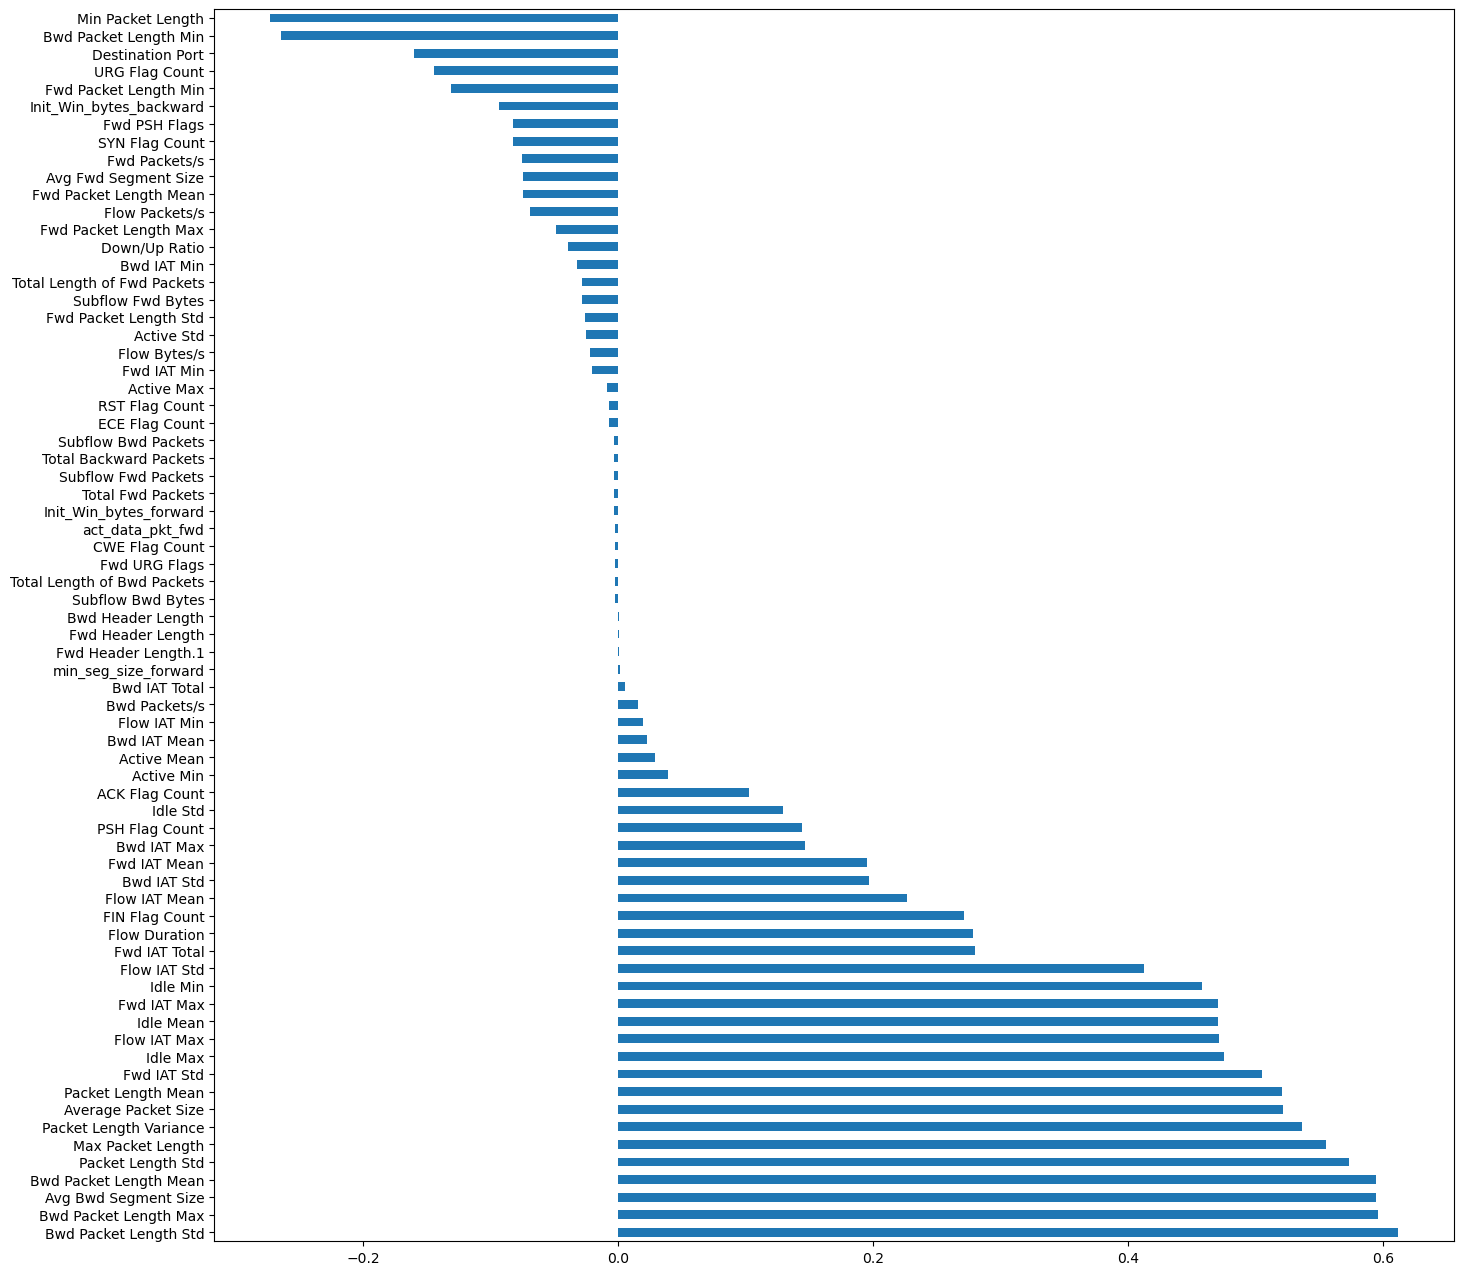

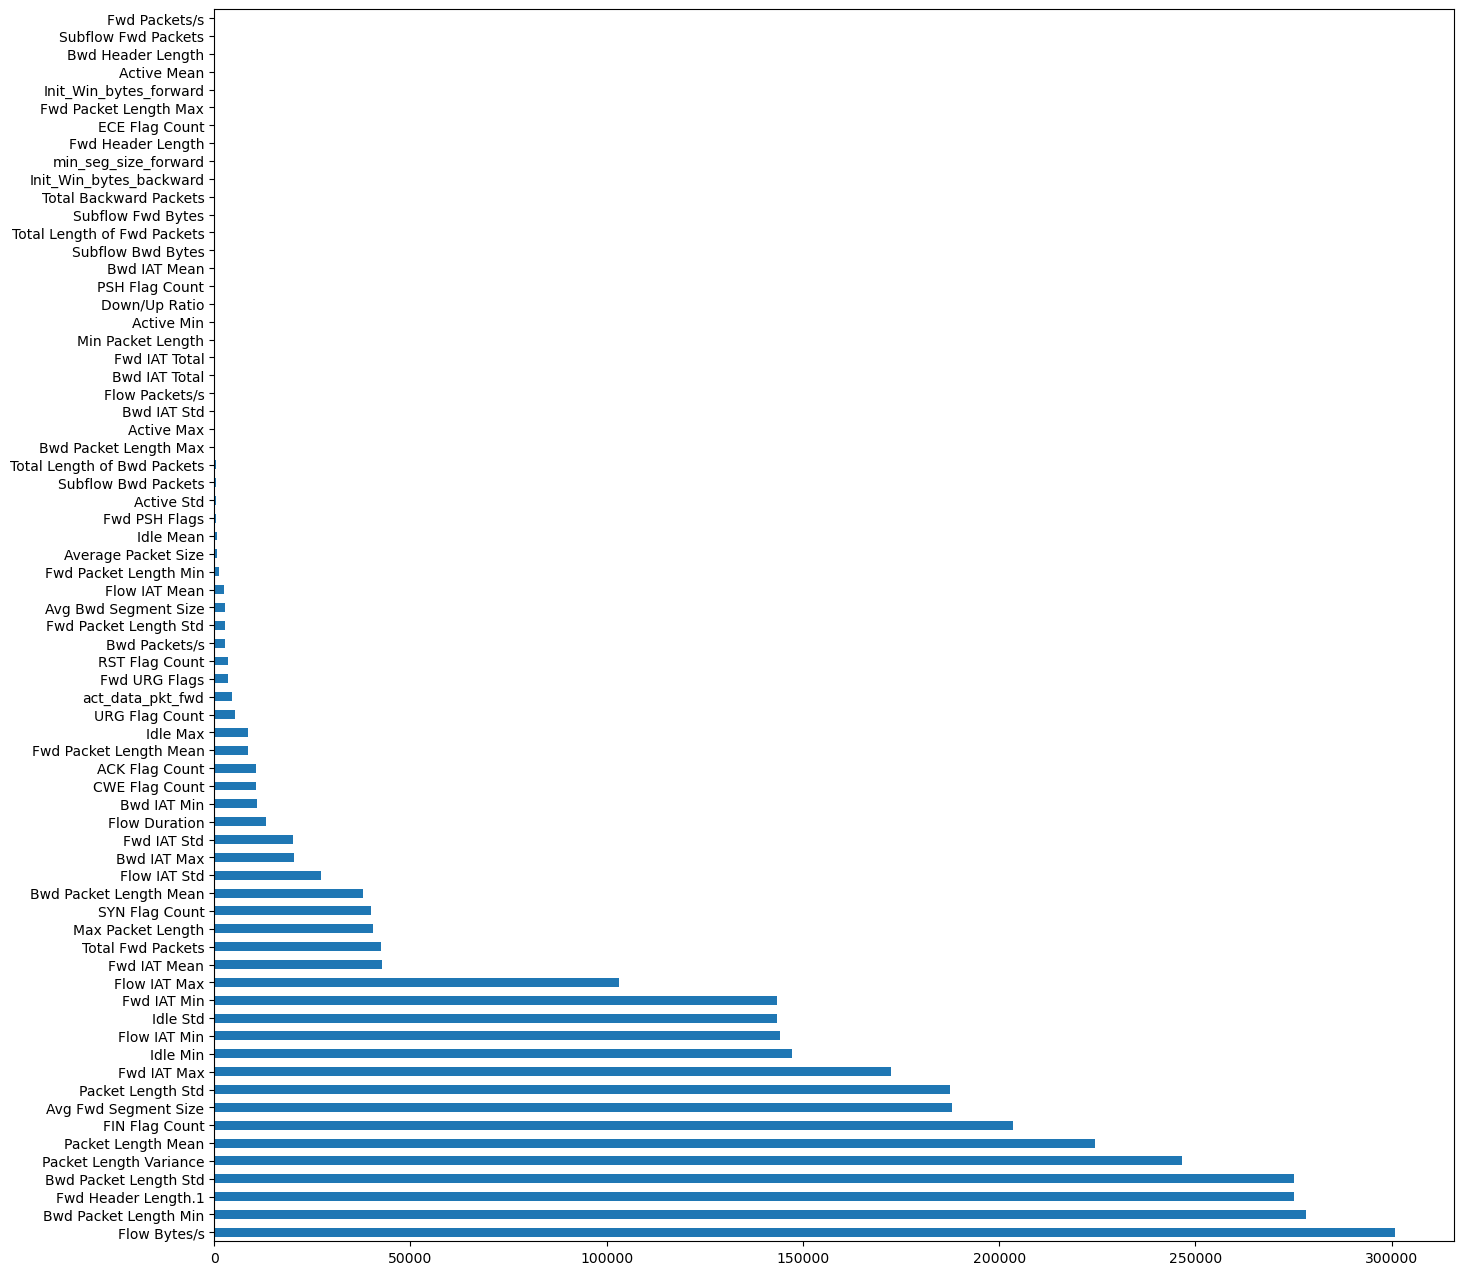

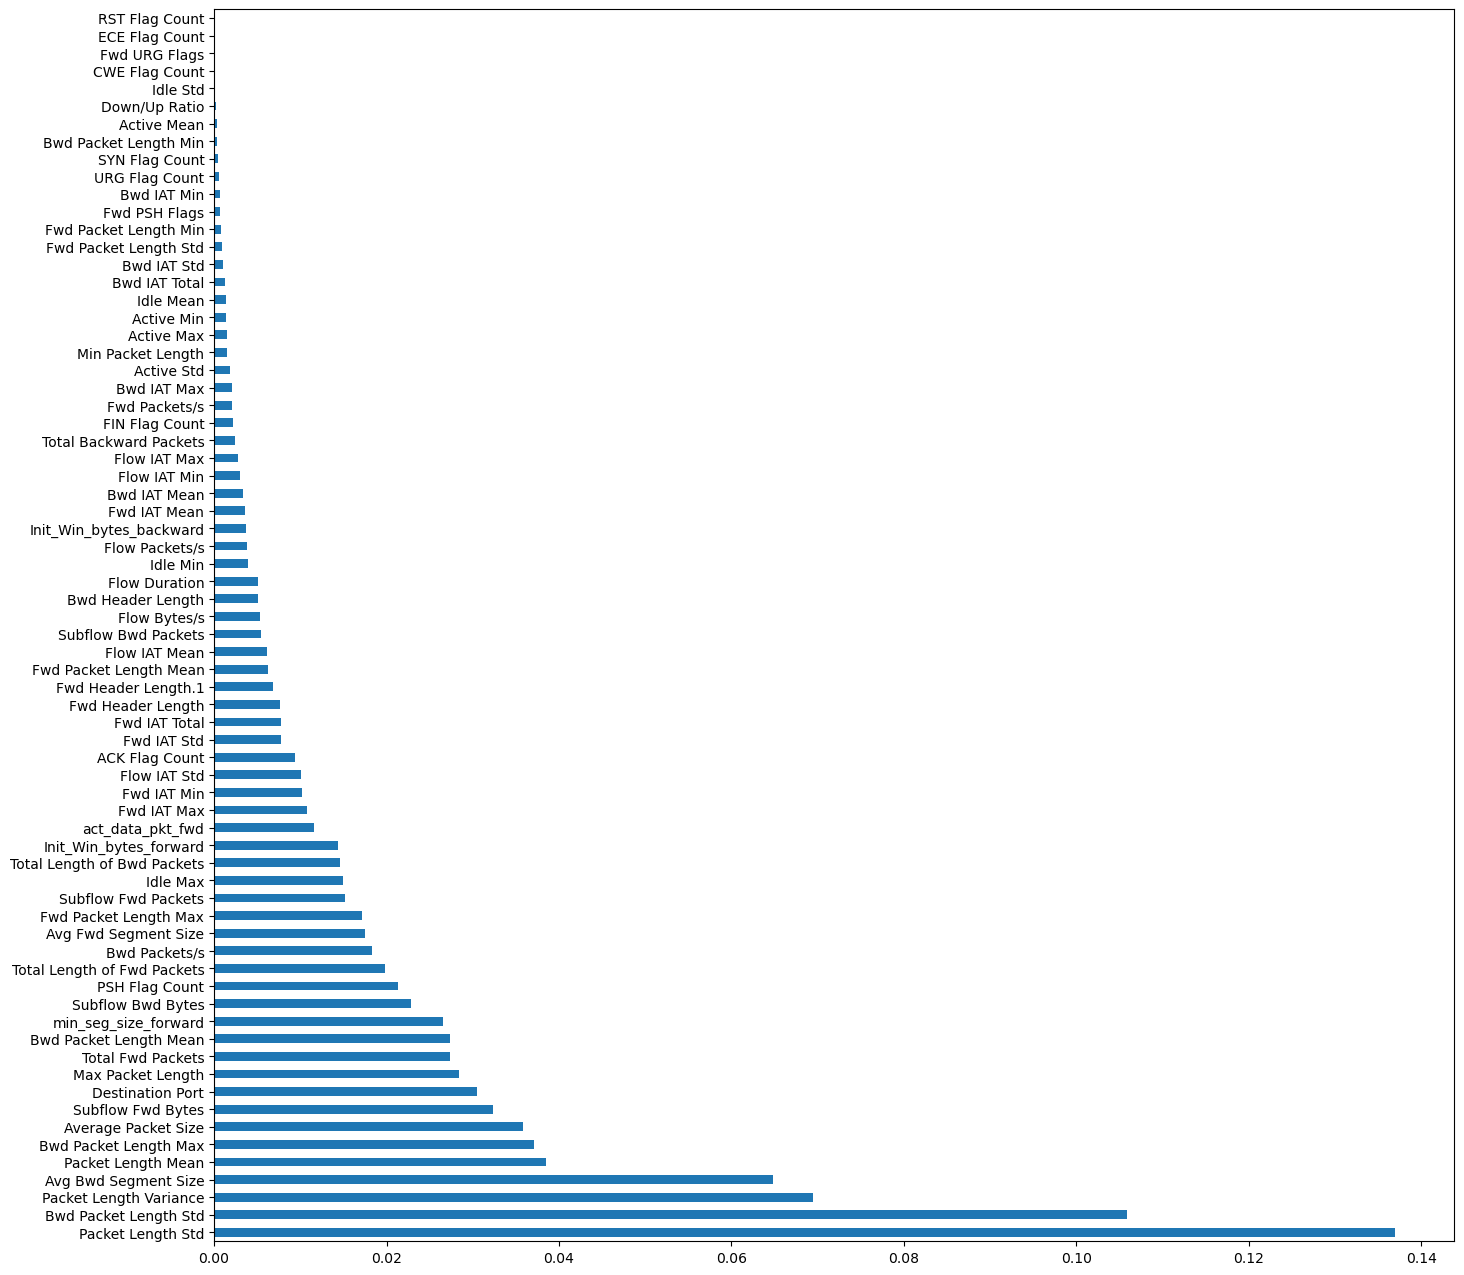

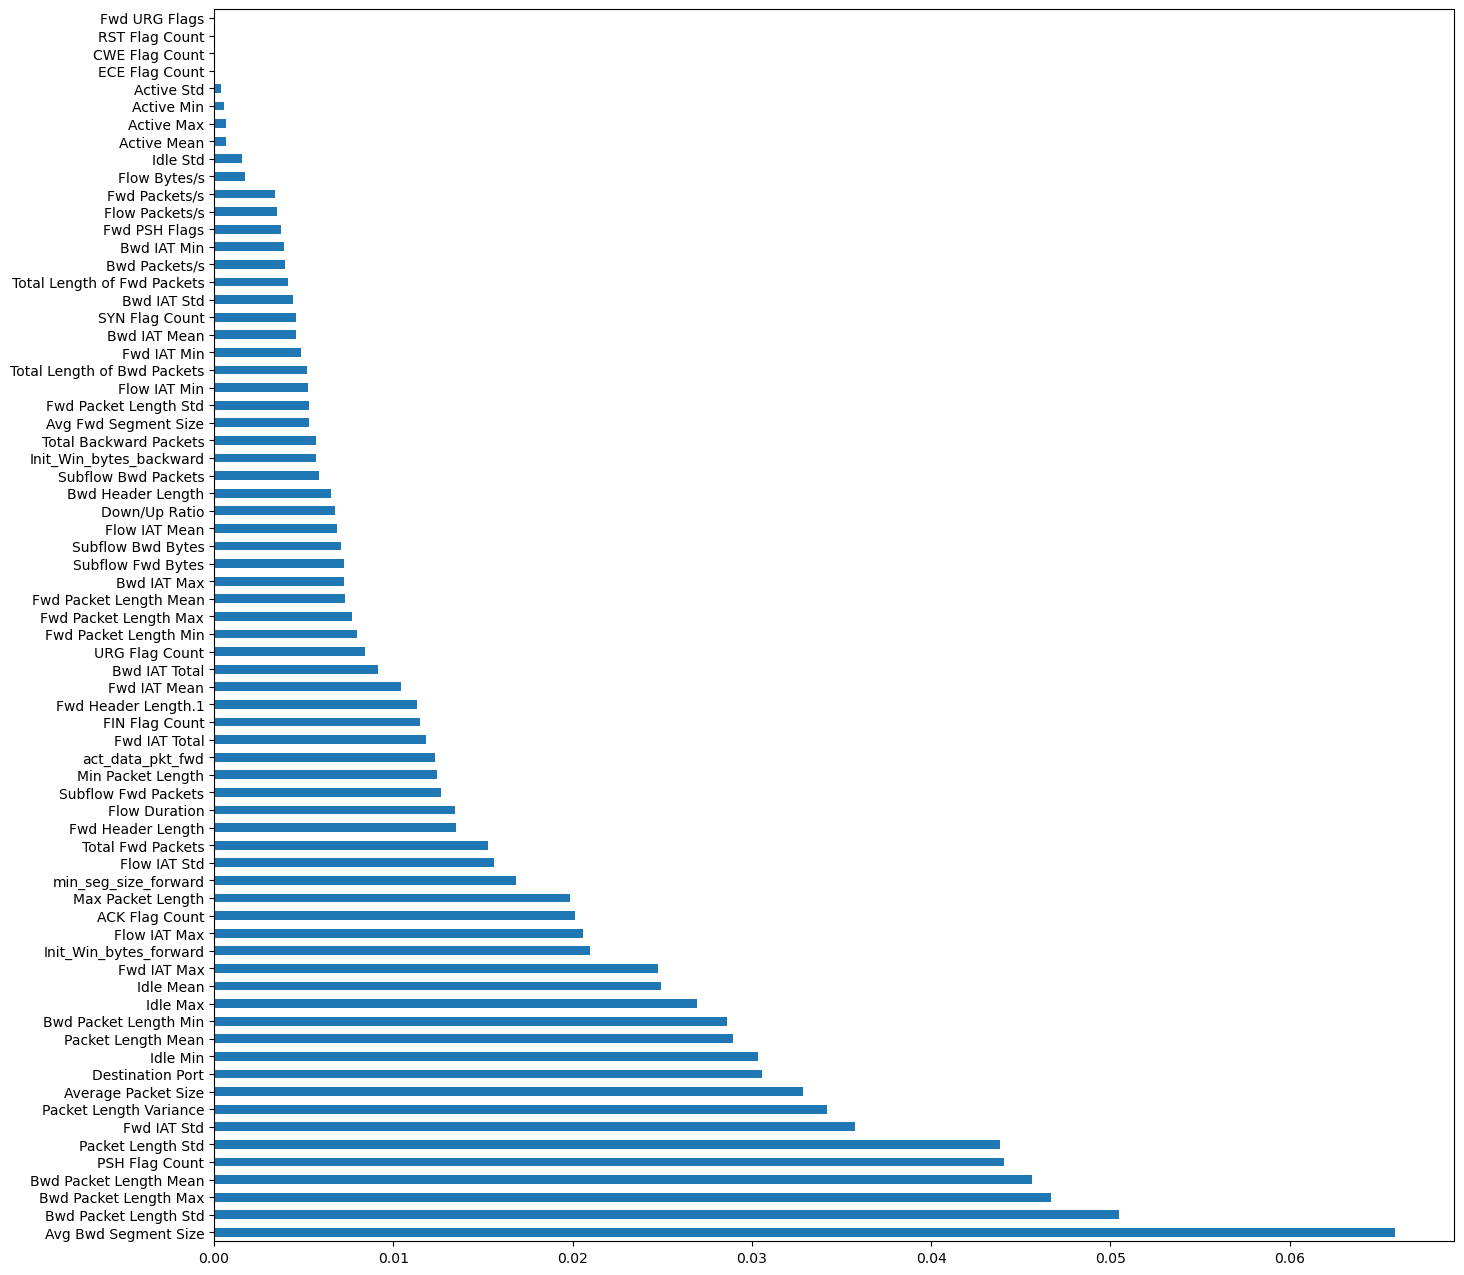

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.611e+04, tolerance: 7.077e+00
  model = cd_fast.enet_coordinate_descent(


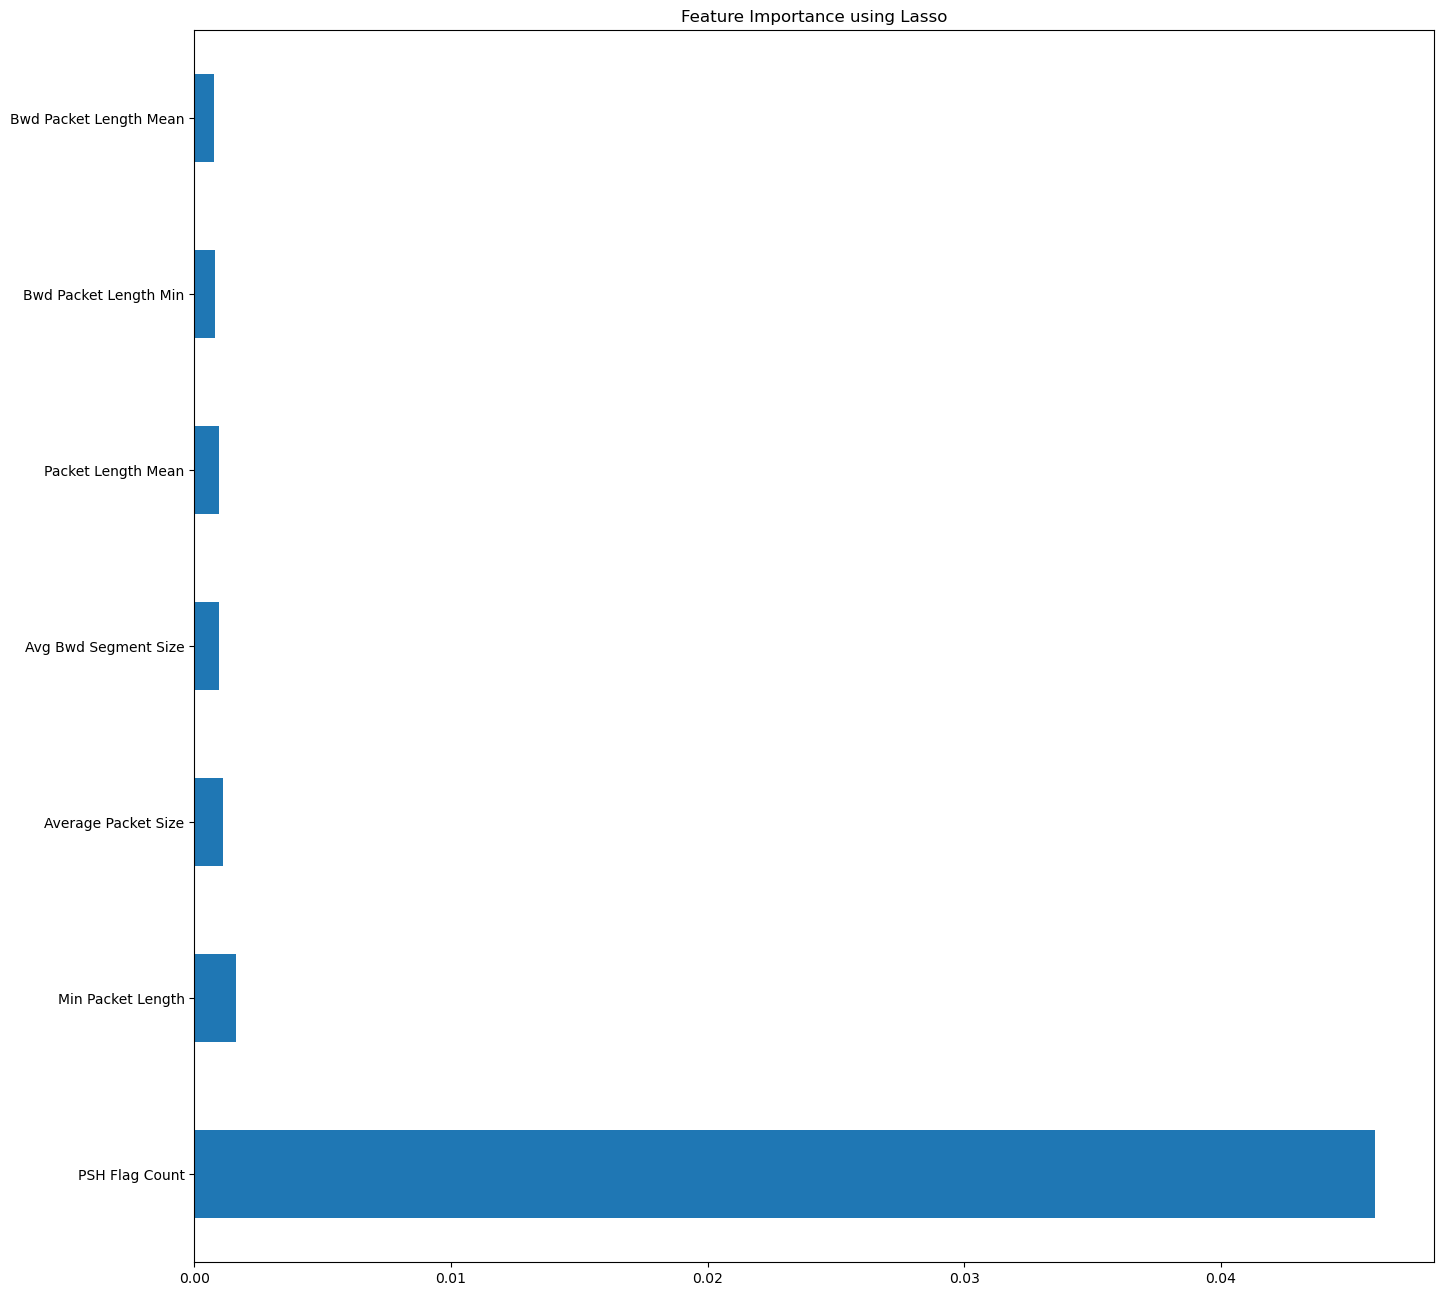

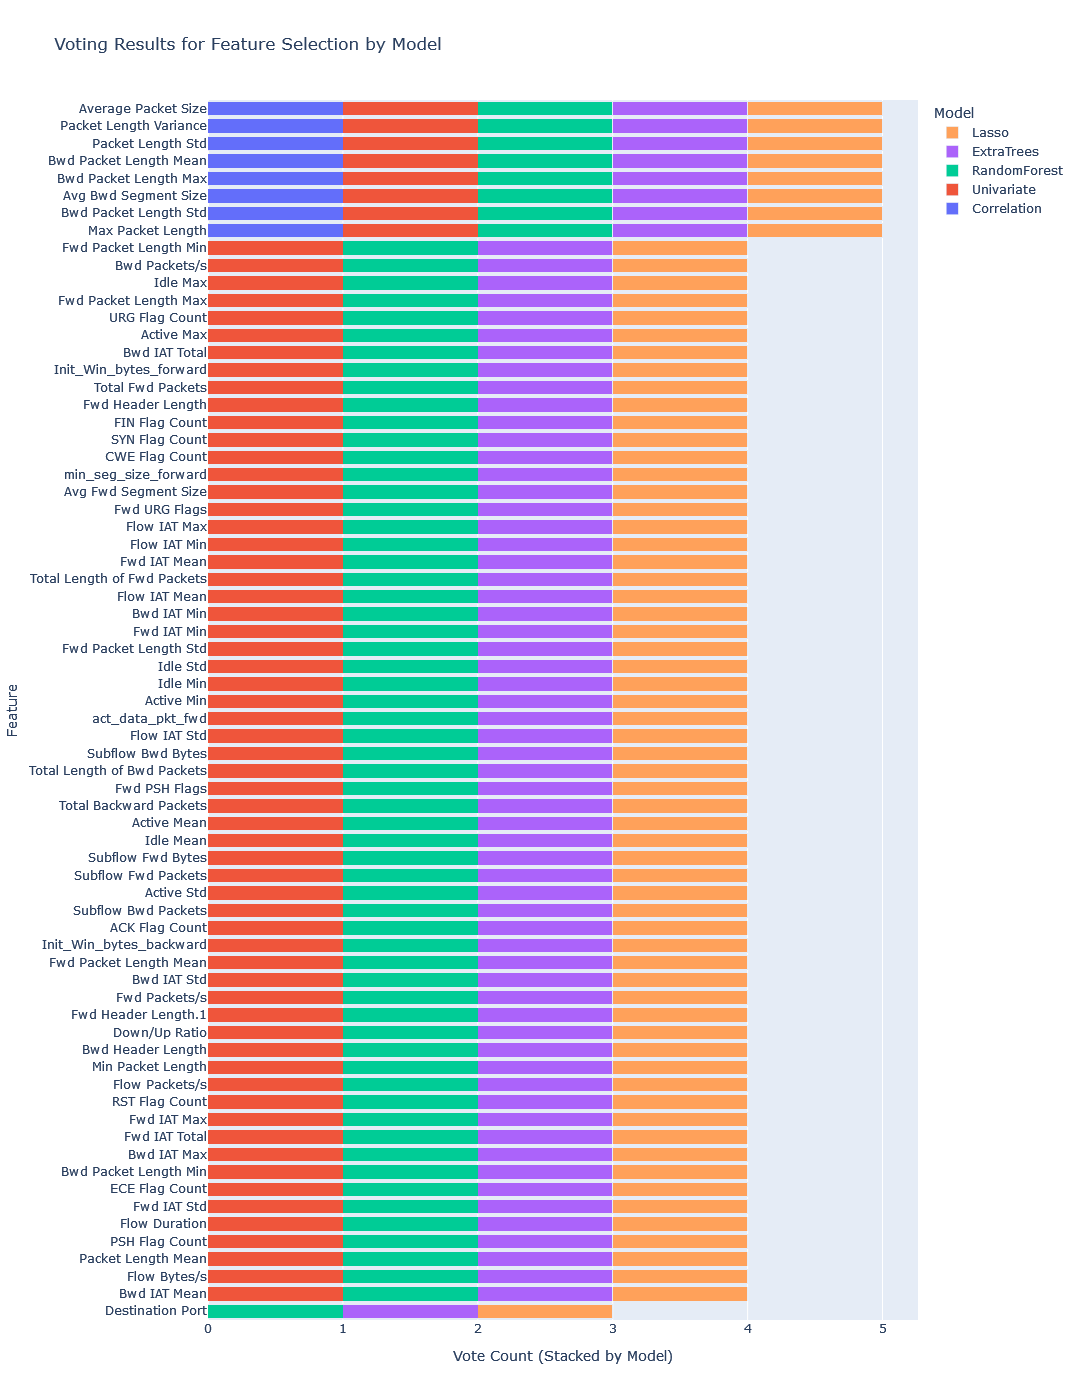

In [83]:

# Run each feature selection method
correlation_df = correlationSelection(X, y, X.columns, LabelColumnName, dataset, featureNumber)
univariate_df, _ = univariateSelection(X, y, X.columns, LabelColumnName, dataset, featureNumber)
random_forest_df, _ = randomForestSelection(X, y, X.columns, LabelColumnName, dataset, featureNumber)
extra_trees_df, _ = extraTreesSelection(X, y, X.columns, LabelColumnName, dataset, featureNumber)
lasso_df, _ = lassoSelection(X, y, X.columns, LabelColumnName, dataset, featureNumber)
# Reshape correlation_df into the required format
correlation_df = pd.DataFrame({
    'Feature': correlation_df.columns,  # Features as rows
    'score': correlation_df.iloc[0]     # Use corresponding scores if available
})
# Apply voting system
votes_df = votingSystem(correlation_df, univariate_df, random_forest_df, extra_trees_df, lasso_df)

# Plot results
import plotly.graph_objects as go

votes_df_plot = votes_df.sort_values('Total Votes').drop(columns=['Total Votes']).T

fig = go.Figure()
for model in votes_df_plot.index:
    fig.add_trace(go.Bar(y=votes_df_plot.columns, x=votes_df_plot.loc[model], name=model, orientation='h'))
    
fig.update_layout(
    title="Voting Results for Feature Selection by Model",
    xaxis_title="Vote Count (Stacked by Model)",
    yaxis_title="Feature",
    barmode='stack',
    height=20 * len(votes_df_plot.columns),
    legend_title="Model"
)

fig.show()


In [81]:
print("Correlation DF Columns:", correlation_df.columns)
print("Univariate DF Columns:", univariate_df.columns)
print("Random Forest DF Columns:", random_forest_df.columns)
print("Extra Trees DF Columns:", extra_trees_df.columns)
print("Lasso DF Columns:", lasso_df.columns)


Correlation DF Columns: Index(['Average Packet Size', 'Packet Length Variance', 'Max Packet Length',
       'Packet Length Std', 'Avg Bwd Segment Size', 'Bwd Packet Length Mean',
       'Bwd Packet Length Max', 'Bwd Packet Length Std'],
      dtype='object')
Univariate DF Columns: Index(['Feature', 'score'], dtype='object')
Random Forest DF Columns: Index(['Feature', 'score'], dtype='object')
Extra Trees DF Columns: Index(['Feature', 'score'], dtype='object')
Lasso DF Columns: Index(['Feature', 'score'], dtype='object')


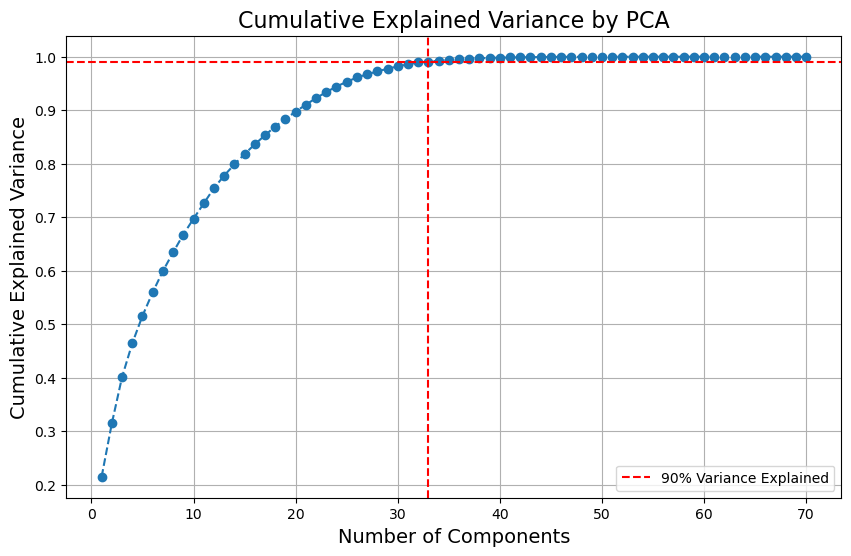

Number of components to explain 99% variance: 33


In [9]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
# Assuming `X` is your feature matrix
pca = PCA()
pca.fit(scaled_X)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot cumulative variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance', fontsize=14)
plt.title('Cumulative Explained Variance by PCA', fontsize=16)
plt.axhline(y=0.99, color='r', linestyle='--', label='90% Variance Explained')  # Add target line
plt.axvline(x=np.argmax(cumulative_variance >= 0.99) + 1, color='r', linestyle='--')  # Add vertical line for 90%
plt.legend()
plt.grid()
plt.show()

# Number of components to explain 90% variance
n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1
print(f"Number of components to explain 99% variance: {n_components_99}")


In [97]:
print(cumulative_variance)

[0.21528847 0.31495002 0.40146799 0.46448879 0.51583662 0.55976824
 0.59947114 0.63443549 0.66777356 0.69730998 0.72586675 0.75436913
 0.77794451 0.79872715 0.8181916  0.83628098 0.85334087 0.86946282
 0.88380714 0.89743569 0.91035021 0.92270522 0.93391735 0.94430733
 0.95313446 0.96121248 0.96721487 0.97254092 0.97752582 0.98197338
 0.98574006 0.98938062 0.99103648 0.99251072 0.99394302 0.99524853
 0.99638872 0.99728333 0.99788288 0.9982678  0.99859674 0.99887544
 0.99913019 0.99934552 0.99952313 0.99966748 0.99975907 0.99981075
 0.99985254 0.99988864 0.99992146 0.99994806 0.99996241 0.99997392
 0.99998168 0.99998812 0.99999273 0.99999675 0.9999989  1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


In [11]:
# Apply PCA with the chosen number of components
pca_optimal = PCA(n_components=n_components_99)
X_reduced = pca_optimal.fit_transform(X)


In [13]:
X_reduced

array([[-3.45011707e+07, -2.92277412e+06, -1.82322139e+06, ...,
        -2.25738686e+02, -7.39390750e+03, -7.69609582e+03],
       [-3.45303183e+07, -2.92827536e+06, -1.46785720e+06, ...,
        -1.58624477e+02, -7.56950653e+03, -7.93185551e+03],
       [-3.44590418e+07, -2.92270562e+06, -1.82189588e+06, ...,
        -3.31497740e+02, -7.34720361e+03, -7.99263395e+03],
       ...,
       [ 2.15762983e+08,  6.08227950e+07,  1.70860446e+06, ...,
        -2.48963653e+04,  1.46571021e+04, -1.19341836e+04],
       [ 1.97004445e+08,  5.00492613e+07,  1.35861271e+06, ...,
        -1.41658293e+05,  2.02242507e+04, -1.21844628e+04],
       [ 1.28345443e+08,  9.96753916e+06,  1.40140494e+05, ...,
        -7.53546088e+04, -2.14817354e+03, -3.51158998e+03]])

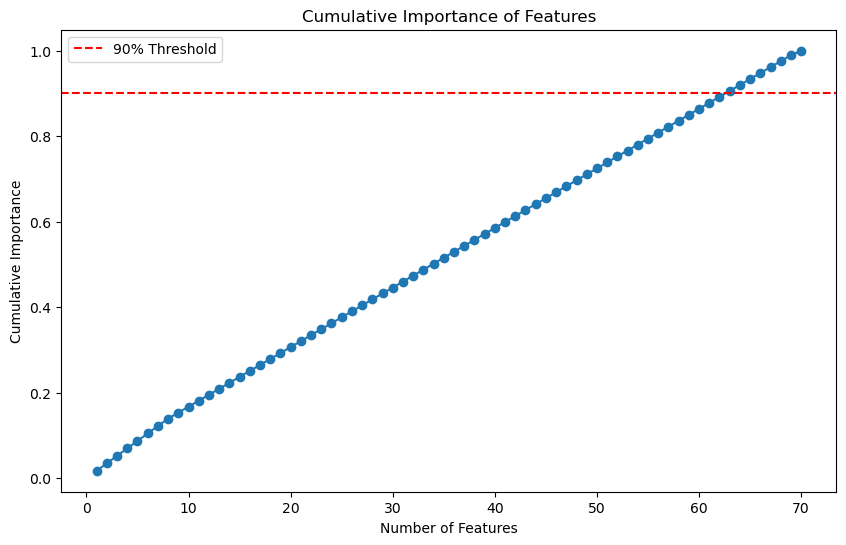

Number of features needed to capture 90.0% importance: 62


In [85]:
import numpy as np
import matplotlib.pyplot as plt

# Normalize the total votes
votes_df['TotalVotes'] = votes_df.sum(axis=1)
votes_df['NormalizedVotes'] = votes_df['TotalVotes'] / votes_df['TotalVotes'].sum()

# Sort features by importance
votes_df = votes_df.sort_values('NormalizedVotes', ascending=False)

# Compute cumulative importance
votes_df['CumulativeImportance'] = np.cumsum(votes_df['NormalizedVotes'])

# Plot cumulative importance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(votes_df) + 1), votes_df['CumulativeImportance'], marker='o', linestyle='-')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Threshold')
plt.title('Cumulative Importance of Features')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.legend()
plt.show()

# Select number of features to reach the threshold
threshold = 0.9
num_features = (votes_df['CumulativeImportance'] <= threshold).sum()
print(f"Number of features needed to capture {threshold*100}% importance: {num_features}")


In [19]:
# Creating new dataset using pca 
new_data = pd.DataFrame(X_reduced, columns = [f'PC{i+1}' for i in range(n_components_99)])
new_data['Target'] = y.values


In [21]:
new_data

PC1           PC2           PC3           PC4           PC5  \
0      -3.450117e+07 -2.922774e+06 -1.823221e+06  7.315623e+04  1.083960e+06   
1      -3.453032e+07 -2.928275e+06 -1.467857e+06  7.342309e+04  1.090034e+06   
2      -3.445904e+07 -2.922706e+06 -1.821896e+06  7.256346e+04  1.071473e+06   
3      -3.464863e+07 -3.111214e+06  1.047685e+07  6.974290e+04  1.039429e+06   
4      -3.453105e+07 -2.929779e+06 -1.375967e+06  7.337194e+04  1.089506e+06   
...              ...           ...           ...           ...           ...   
503592  1.453185e+08  6.139482e+07  9.470575e+05  2.546097e+05  3.627517e+06   
503593  1.738598e+08  7.442705e+07  1.428854e+06  3.275754e+05  4.172354e+06   
503594  2.157630e+08  6.082280e+07  1.708604e+06  9.598965e+05  1.616639e+07   
503595  1.970044e+08  5.004926e+07  1.358613e+06  9.867237e+05  1.780757e+07   
503596  1.283454e+08  9.967539e+06  1.401405e+05  2.181021e+06  5.485114e+07   

                 PC6           PC7           PC8           PC9          PC10  \
0      -6.579679e+05  3.433713e+05 -1.625782e+05 -2.256371e+05 -4.229437e+04   
1      -6.700349e+05  3.570061e+05 -1.933912e+05 -2.234751e+05 -4.336199e+04   
2      -6.371375e+05  3.205161e+05 -1.117348e+05 -2.289521e+05 -4.025129e+04   
3      -6.495190e+05  3.484738e+05 -1.893523e+05 -2.191881e+05 -4.398607e+04   
4      -6.699249e+05  3.567543e+05 -1.932880e+05 -2.234068e+05 -4.318010e+04   
...              ...           ...           ...           ...           ...   
503592 -1.929933e+07 -4.676201e+07 -6.292074e+06 -2.089099e+07 -2.994093e+05   
503593 -1.929229e+07 -4.422789e+07 -3.126994e+06 -1.086156e+07 -3.122348e+05   
503594 -1.936380e+07  1.403247e+06  8.177046e+06  1.426605e+07 -4.047429e+05   
503595 -1.798050e+07 -8.275010e+06  9.249664e+06  9.688544e+06 -7.781728e+05   
503596  1.811178e+07 -5.598414e+07 -4.418959e+07  1.580335e+07  1.717905e+06   

        ...           PC25          PC26          PC27          PC28  \
0       ...  -76572.368021 -2.911598e+02 -7.211301e+03 -4.538731e+02   
1       ...  -72709.627215 -3.817871e+02 -6.800880e+03 -3.465365e+02   
2       ...  -76171.991832 -1.356663e+02 -7.809968e+03 -6.266381e+02   
3       ...  829298.430589  2.587330e+02  2.793403e+03 -3.116218e+01   
4       ...  -74269.628316 -3.708639e+02 -6.772458e+03 -3.406216e+02   
...     ...            ...           ...           ...           ...   
503592  ...  -17865.746059 -1.590137e+06 -5.624844e+05  9.986771e+04   
503593  ...  -24703.537956 -1.480134e+04 -1.136345e+06 -1.116307e+06   
503594  ...   -6569.184182  2.644441e+04  3.004214e+06  6.723406e+05   
503595  ...  -66625.996381  5.133583e+04  6.190806e+06 -4.143760e+04   
503596  ...   27269.266672  1.435299e+05  9.450657e+05 -1.148816e+05   

                PC29          PC30           PC31          PC32          PC33  \
0       2.569285e+02  -7212.392733    -225.738686  -7393.907498  -7696.095818   
1       4.804336e+02  -4491.372867    -158.624477  -7569.506530  -7931.855512   
2      -1.132753e+02  -7194.280538    -331.497740  -7347.203615  -7992.633948   
3       2.883862e+01 -45381.687239    -319.803398  31763.480910   1757.237919   
4       4.346037e+02  -5179.406290    -162.203844  -7518.666871  -7927.589984   
...              ...           ...            ...           ...           ...   
503592  4.584904e+05  -2471.661060  284649.687100  -4053.975245 -14950.506292   
503593  8.679262e+05  -2660.416604 -171342.365393 -10022.180399 -10101.692374   
503594  2.052205e+06   4722.060083  -24896.365301  14657.102068 -11934.183642   
503595  4.273783e+06   5159.686337 -141658.293229  20224.250696 -12184.462774   
503596 -2.220882e+03   3908.447883  -75354.608829  -2148.173537  -3511.589978   

        Target  
0            0  
1            0  
2            0  
3            0  
4            0  
...        ...  
503592       0  
503593       0  
503594       0  
503595       0  
503596       0  

[503597 rows x 34 columns]

In [25]:
scaled_X

array([[-4.53104435e-01, -4.69854045e-01, -1.29530797e-02, ...,
        -1.16258323e-01, -3.81101837e-01, -3.61705440e-01],
       [-4.54524416e-01, -4.70776119e-01, -1.29530797e-02, ...,
        -1.16258323e-01, -3.81101837e-01, -3.61705440e-01],
       [-4.54524416e-01, -4.68339152e-01, -1.29530797e-02, ...,
        -1.16258323e-01, -3.81101837e-01, -3.61705440e-01],
       ...,
       [-4.34013584e-01,  2.93255115e+00, -7.11438040e-03, ...,
        -3.64951929e-02,  1.91239307e+00,  2.00876734e+00],
       [-4.34013584e-01,  2.59776987e+00, -8.57405523e-03, ...,
         1.16835633e+00,  1.89676449e+00,  1.65441831e+00],
       [-4.34013584e-01,  1.34781749e+00, -8.57405523e-03, ...,
         7.42240080e+00,  1.88504305e+00, -1.19186729e-01]])

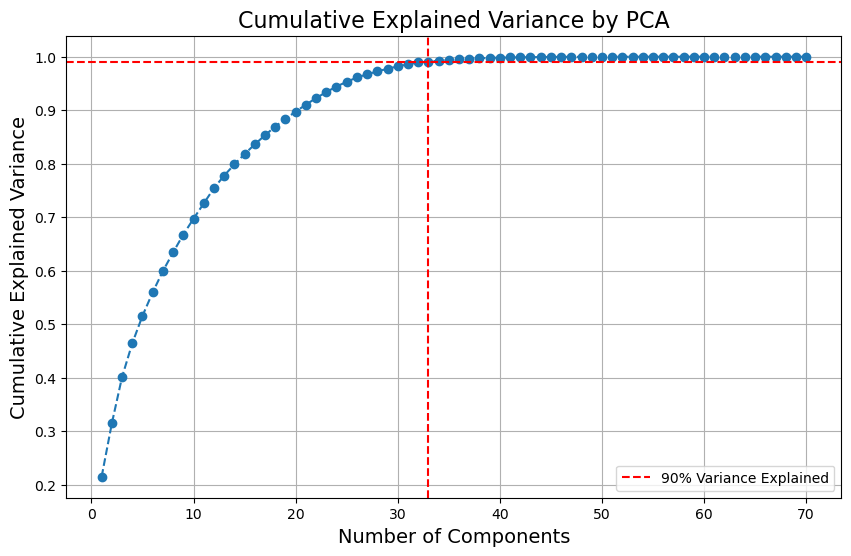

Number of components to explain 99% variance: 33


In [37]:
from sklearn.decomposition import IncrementalPCA

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

ipca = IncrementalPCA()
for batch in np.array_split(scaled_X, len(X) // 500):
    ipca.partial_fit(batch)


# Explained variance ratio
explained_variance_ratio = ipca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot cumulative variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance', fontsize=14)
plt.title('Cumulative Explained Variance by PCA', fontsize=16)
plt.axhline(y=0.99, color='r', linestyle='--', label='90% Variance Explained')  # Add target line
plt.axvline(x=np.argmax(cumulative_variance >= 0.99) + 1, color='r', linestyle='--')  # Add vertical line for 90%
plt.legend()
plt.grid()
plt.show()

# Number of components to explain 90% variance
n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1
print(f"Number of components to explain 99% variance: {n_components_99}")


In [65]:
# Standardizing the dataset
from sklearn.preprocessing import StandardScaler

features = dataset.drop('Target', axis = 1)
attacks = dataset['Target']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
from sklearn.decomposition import IncrementalPCA

size = 35
ipca = IncrementalPCA(n_components = size, batch_size = 500)
for batch in np.array_split(scaled_features, len(features) // 500):
    ipca.partial_fit(batch)

print(f'information retained: {sum(ipca.explained_variance_ratio_):.2%}')

transformed_features = ipca.transform(scaled_features)


information retained: 99.34%


In [190]:
new_data = pd.DataFrame(transformed_features, columns = [f'PC{i+1}' for i in range(size)])
new_data['Target'] = attacks.values
new_data

PC1       PC2       PC3       PC4       PC5        PC6       PC7  \
0      -2.099890 -0.102020  0.385860 -0.139719  1.005196   0.022553 -0.009299   
1      -2.023648 -0.070306  0.214943 -0.495158 -1.201667  -0.936999 -0.101006   
2      -2.035428 -0.070751  0.248972 -0.447948 -1.172786  -0.898449 -0.095563   
3      -2.395295 -0.087404  1.019133  1.401806  6.768270   0.408293 -0.079100   
4      -1.948717 -0.072914  0.104890 -0.700422 -1.463411  -1.187518 -0.130937   
...          ...       ...       ...       ...       ...        ...       ...   
503592  4.055337  0.727081  3.292411  5.111301 -4.380862  11.450245  0.333457   
503593  3.829641 -0.727152  4.385370  1.540384  2.886781   1.263874 -0.024120   
503594  6.465178 -1.009144  6.693097  2.201776  1.977312   4.005968  0.109038   
503595  5.613189 -1.209062  6.180474  1.017468  2.765589   0.760852 -0.028569   
503596  5.139060 -1.558846  8.223281  0.702749  2.573292  -0.433357 -0.052474   

             PC8       PC9      PC10  ...      PC27      PC28      PC29  \
0      -0.688212 -0.749860  1.987473  ...  0.003148 -0.212095 -1.614311   
1      -0.607933  0.845342 -0.222531  ... -0.049951 -0.031634 -0.105508   
2      -0.589420  0.774229 -0.187226  ... -0.106298 -0.072860 -0.181069   
3       1.352537  2.360250 -2.512552  ... -0.018722  0.157638  0.861657   
4      -0.685674  1.205879 -0.318208  ...  0.176648  0.138844  0.224592   
...          ...       ...       ...  ...       ...       ...       ...   
503592 -3.724989  7.647847  0.760318  ... -1.863340  0.367578  0.126991   
503593 -2.323943  1.065294 -2.733885  ... -0.040204 -0.264427 -0.463269   
503594 -2.637432  2.711190 -2.530920  ... -1.718639 -0.494180 -0.800304   
503595 -2.318831  0.864167 -2.648257  ... -0.871094 -0.489037 -0.740308   
503596  2.081328  1.701965 -1.340021  ...  0.203778 -0.190479 -0.367268   

            PC30      PC31      PC32      PC33      PC34      PC35  Target  
0       1.091111 -0.436491 -0.252111 -0.092401  0.225632 -0.016829       0  
1      -0.057012  0.344579 -0.202870  0.034737 -0.128804 -0.033567       0  
2      -0.084584  0.583316 -0.377943  0.047374 -0.160892 -0.049243       0  
3       0.169335  0.468702  0.152790  0.054377 -0.246920  0.111331       0  
4       0.072945 -0.569640  0.475936 -0.019013  0.070715  0.013992       0  
...          ...       ...       ...       ...       ...       ...     ...  
503592 -0.177011  0.867887 -0.174803  0.988434 -0.192857 -0.474635       0  
503593 -0.532706  0.286084 -0.566158  0.210652  0.213174 -0.365746       0  
503594 -0.729468  0.439641  0.018649 -1.700742  0.257182  0.866466       0  
503595 -0.900642  0.549698 -0.115851 -1.540530  0.154674  0.873555       0  
503596  0.434558  0.020855 -0.418331  0.774974  1.651998 -2.490481       0  

[503597 rows x 36 columns]

In [188]:
new_data.to_csv("pca_data.csv", index=False)

In [192]:
new_data['Target'].value_counts()

Target
0    418425
1     85172
Name: count, dtype: int64

In [79]:
from sklearn.model_selection import train_test_split
X_new = new_data.drop('Target', axis = 1)
y_new = new_data['Target']

X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size = 0.3, random_state = 0)
     

### Logistic regression 

In [82]:
# For cross validation
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

lr1 = LogisticRegression(max_iter = 10000, C = 0.1, random_state = 0, solver = 'saga')
lr1.fit(X_train, y_train)

cv_lr1 = cross_val_score(lr1, X_train, y_train, cv = 5)
print('Logistic regression Model 1')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_lr1)))
print(f'\nMean cross-validation score: {cv_lr1.mean():.2f}')

Logistic regression Model 1

Cross-validation scores: 0.9434358334278906, 0.9438329740156587, 0.9461157681233423, 0.9449385132547551, 0.9452789243010936

Mean cross-validation score: 0.94


In [84]:
print('Logistic Regression Model 1 coefficients:')
print(*lr1.coef_, sep = ', ')
print('\nLogistic Regression Model 1 intercept:', *lr1.intercept_)

Logistic Regression Model 1 coefficients:
[ 0.55475562 -0.82217088 -0.76518753 -2.29969054  0.86985689  1.2111195
  0.07334363  0.63287929 -0.31123624  0.33396738 -0.15865983 -0.05903367
 -0.05949092  0.29237805  0.77961781  0.09736782 -1.06146374  0.02018683
  0.24532484  0.68318823 -0.51291136 -1.11121137  0.51823568  2.66638809
 -0.85415287 -2.56548347 -1.9328259  -1.31248299 -0.67721214 -1.36612982
  2.12880558  0.34175401 -2.97753721 -0.21322681 -2.95761152]

Logistic Regression Model 1 intercept: -5.213162975766492


In [88]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the model
lr = LogisticRegression(random_state=0)

# Define the parameter grid
param_grid = {
    'solver': ['saga', 'liblinear', 'lbfgs', 'newton-cg'],  # Try different solvers
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'max_iter': [100, 500, 1000, 5000, 10000]  # Iterations
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring='accuracy',  # Use a metric that fits your problem (e.g., 'roc_auc', 'f1')
    cv=5,  # Number of folds for cross-validation
    verbose=2,  # Higher verbosity for tracking progress
    n_jobs=-1  # Use all available cores for parallel processing
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Display best parameters and score
print("Best hyperparameters:", grid_search.best_params_)
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")

# Get the best estimator
best_lr = grid_search.best_estimator_

# Evaluate on cross-validation set
cv_best_lr = cross_val_score(best_lr, X_train, y_train, cv=5)
print(f"\nCross-validation scores with best model: {', '.join(map(str, cv_best_lr))}")
print(f"\nMean cross-validation score: {cv_best_lr.mean():.2f}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best hyperparameters: {'C': 100, 'max_iter': 100, 'solver': 'newton-cg'}
Best cross-validation score: 0.95

Cross-validation scores with best model: 0.9514921139226143, 0.9518467037331215, 0.9512219338184191, 0.9500588627434293, 0.9529523566373063

Mean cross-validation score: 0.95


In [167]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the model
svc = SVC(random_state=0)

# Define the parameter grid
param_grid_svm = {
    'C': [1, 10],  # Reduced C values
    'kernel': ['rbf', "poly"],  # Focus on RBF kernel if likely more important
    'probability': [True] 
}

grid_search_svm = GridSearchCV(
    estimator=svc,
    param_grid=param_grid_svm,
    scoring='accuracy',
    cv=2,
    verbose=2,
    n_jobs=-1
)

# Fit the grid search to the data
grid_search_svm.fit(X_train, y_train)

print("Best hyperparameters for SVM:", grid_search_svm.best_params_)
print(f"Best cross-validation score for SVM: {grid_search_svm.best_score_:.2f}")


Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best hyperparameters for SVM: {'C': 10, 'kernel': 'rbf', 'probability': True}
Best cross-validation score for SVM: 0.97


In [168]:
print(grid_search_svm)

GridSearchCV(cv=2, estimator=SVC(random_state=0), n_jobs=-1,
             param_grid={'C': [1, 10], 'kernel': ['rbf', 'poly'],
                         'probability': [True]},
             scoring='accuracy', verbose=2)


In [172]:
# Get the best estimator for SVM
best_svm = grid_search_svm.best_estimator_


In [124]:
from sklearn.tree import DecisionTreeClassifier

# Define the model
dt = DecisionTreeClassifier(random_state=0)

# Define the parameter grid
param_grid_dt = {
    'max_depth': [5, 8, 10,20]
}

# Set up GridSearchCV
grid_search_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid_dt,
    scoring='accuracy',
    cv=2,
    verbose=2,
    n_jobs=-1
)

# Fit the grid search to the data
grid_search_dt.fit(X_train, y_train)

print("Best hyperparameters for DecisionTreeClassifier:", grid_search_dt.best_params_)
print(f"Best cross-validation score for DecisionTreeClassifier: {grid_search_dt.best_score_:.2f}")

# Get the best estimator for DecisionTreeClassifier
best_dt = grid_search_dt.best_estimator_

# Evaluate on cross-validation set
cv_best_dt = cross_val_score(best_dt, X_train, y_train, cv=5)

print(f"Best DecisionTreeClassifier Model: {best_dt}")
print(f"Cross-validation scores with best DecisionTreeClassifier model: {', '.join(map(str, cv_best_dt))}")
print(f"Mean cross-validation score for DecisionTreeClassifier: {cv_best_dt.mean():.2f}")


Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best hyperparameters for DecisionTreeClassifier: {'max_depth': 20}
Best cross-validation score for DecisionTreeClassifier: 1.00
Best DecisionTreeClassifier Model: DecisionTreeClassifier(max_depth=20, random_state=0)
Cross-validation scores with best DecisionTreeClassifier model: 0.9960995120844207, 0.9966101214115511, 0.9957732295079642, 0.9965533381558231, 0.9959008836503411
Mean cross-validation score for DecisionTreeClassifier: 1.00


In [126]:
from sklearn.ensemble import RandomForestClassifier

# Define the model
rf = RandomForestClassifier(random_state=0)

# Define the parameter grid
param_grid_rf = {
    'n_estimators': [10, 20, 30],
    'max_depth': [5,8, 10, 15]
}

# Set up GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring='accuracy',
    cv=2,
    verbose=2,
    n_jobs=-1
)

# Fit the grid search to the data
grid_search_rf.fit(X_train, y_train)

print("Best hyperparameters for RandomForestClassifier:", grid_search_rf.best_params_)
print(f"Best cross-validation score for RandomForestClassifier: {grid_search_rf.best_score_:.2f}")


# Get the best estimator for RandomForestClassifier
best_rf = grid_search_rf.best_estimator_

# Evaluate on cross-validation set
cv_best_rf = cross_val_score(best_rf, X_train, y_train, cv=5)

print(f"Best RandomForestClassifier Model: {best_rf}")
print(f"Cross-validation scores with best RandomForestClassifier model: {', '.join(map(str, cv_best_rf))}")
print(f"Mean cross-validation score for RandomForestClassifier: {cv_best_rf.mean():.2f}")


Fitting 2 folds for each of 12 candidates, totalling 24 fits
Best hyperparameters for RandomForestClassifier: {'max_depth': 15, 'n_estimators': 30}
Best cross-validation score for RandomForestClassifier: 1.00
Best RandomForestClassifier Model: RandomForestClassifier(max_depth=15, n_estimators=30, random_state=0)
Cross-validation scores with best RandomForestClassifier model: 0.9969363440372178, 0.9966243050039714, 0.996482419187836, 0.9970923223125258, 0.9970497709317334
Mean cross-validation score for RandomForestClassifier: 1.00


In [130]:
from xgboost import XGBClassifier

# Define the model
xgb = XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss')

# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [10, 20, 50],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.6, 1.0],
    'colsample_bytree': [0.6, 1.0]
}

# Set up GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring='accuracy',
    cv=2,
    verbose=2,
    n_jobs=-1
)

# Fit the grid search to the data
grid_search_xgb.fit(X_train, y_train)

print("Best hyperparameters for XGBoostClassifier:", grid_search_xgb.best_params_)
print(f"Best cross-validation score for XGBoostClassifier: {grid_search_xgb.best_score_:.2f}")


# Get the best estimator for XGBoostClassifier
best_xgb = grid_search_xgb.best_estimator_

# Evaluate on cross-validation set
cv_best_xgb = cross_val_score(best_xgb, X_train, y_train, cv=5)

print(f"Best XGBoostClassifier Model: {best_xgb}")
print(f"Cross-validation scores with best XGBoostClassifier model: {', '.join(map(str, cv_best_xgb))}")
print(f"Mean cross-validation score for XGBoostClassifier: {cv_best_xgb.mean():.2f}")


Fitting 2 folds for each of 72 candidates, totalling 144 fits


C:\Users\Dyari Elkamel\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [09:29:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best hyperparameters for XGBoostClassifier: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50, 'subsample': 1.0}
Best cross-validation score for XGBoostClassifier: 1.00


C:\Users\Dyari Elkamel\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [09:29:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Dyari Elkamel\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [09:29:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Dyari Elkamel\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [09:29:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used

Best XGBoostClassifier Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=0, ...)
Cross-validation scores with best XGBoostClassifier model: 0.9968370588902757, 0.9966384885963917, 0.9962838460774719, 0.9966668085046027, 0.9967802788533822
Mean cross-validation score for XGBoostClassifier: 1.00


In [157]:
from sklearn.neighbors import KNeighborsClassifier

# Define the model
knn = KNeighborsClassifier()

# Define the parameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weighting scheme for neighbors
}

# Set up GridSearchCV
grid_search_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid_knn,
    scoring='accuracy',  # You can change this to a different metric (e.g., 'f1-score')
    cv=2,  # Number of cross-validation folds
    verbose=2,  # Verbosity level
    n_jobs=-1  # Use all available cores
)

# Fit the grid search to the data
grid_search_knn.fit(X_train, y_train)

print("Best hyperparameters for KNeighborsClassifier:", grid_search_knn.best_params_)
print(f"Best cross-validation score for KNeighborsClassifier: {grid_search_knn.best_score_:.2f}")

# Get the best estimator for KNeighborsClassifier
best_knn = grid_search_knn.best_estimator_

# Evaluate on cross-validation set (optional)
# You can comment out this section if you don't need separate evaluation
# cv_best_knn = cross_val_score(best_knn, X_train, y_train, cv=5)

# print(f"Best KNeighborsClassifier Model: {best_knn}")
# print(f"Cross-validation scores with best KNeighborsClassifier model: {', '.join(map(str, cv_best_knn))}")
# print(f"Mean cross-validation score for KNeighborsClassifier: {cv_best_knn.mean():.2f}")

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best hyperparameters for KNeighborsClassifier: {'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score for KNeighborsClassifier: 0.99


### Model Evaluation

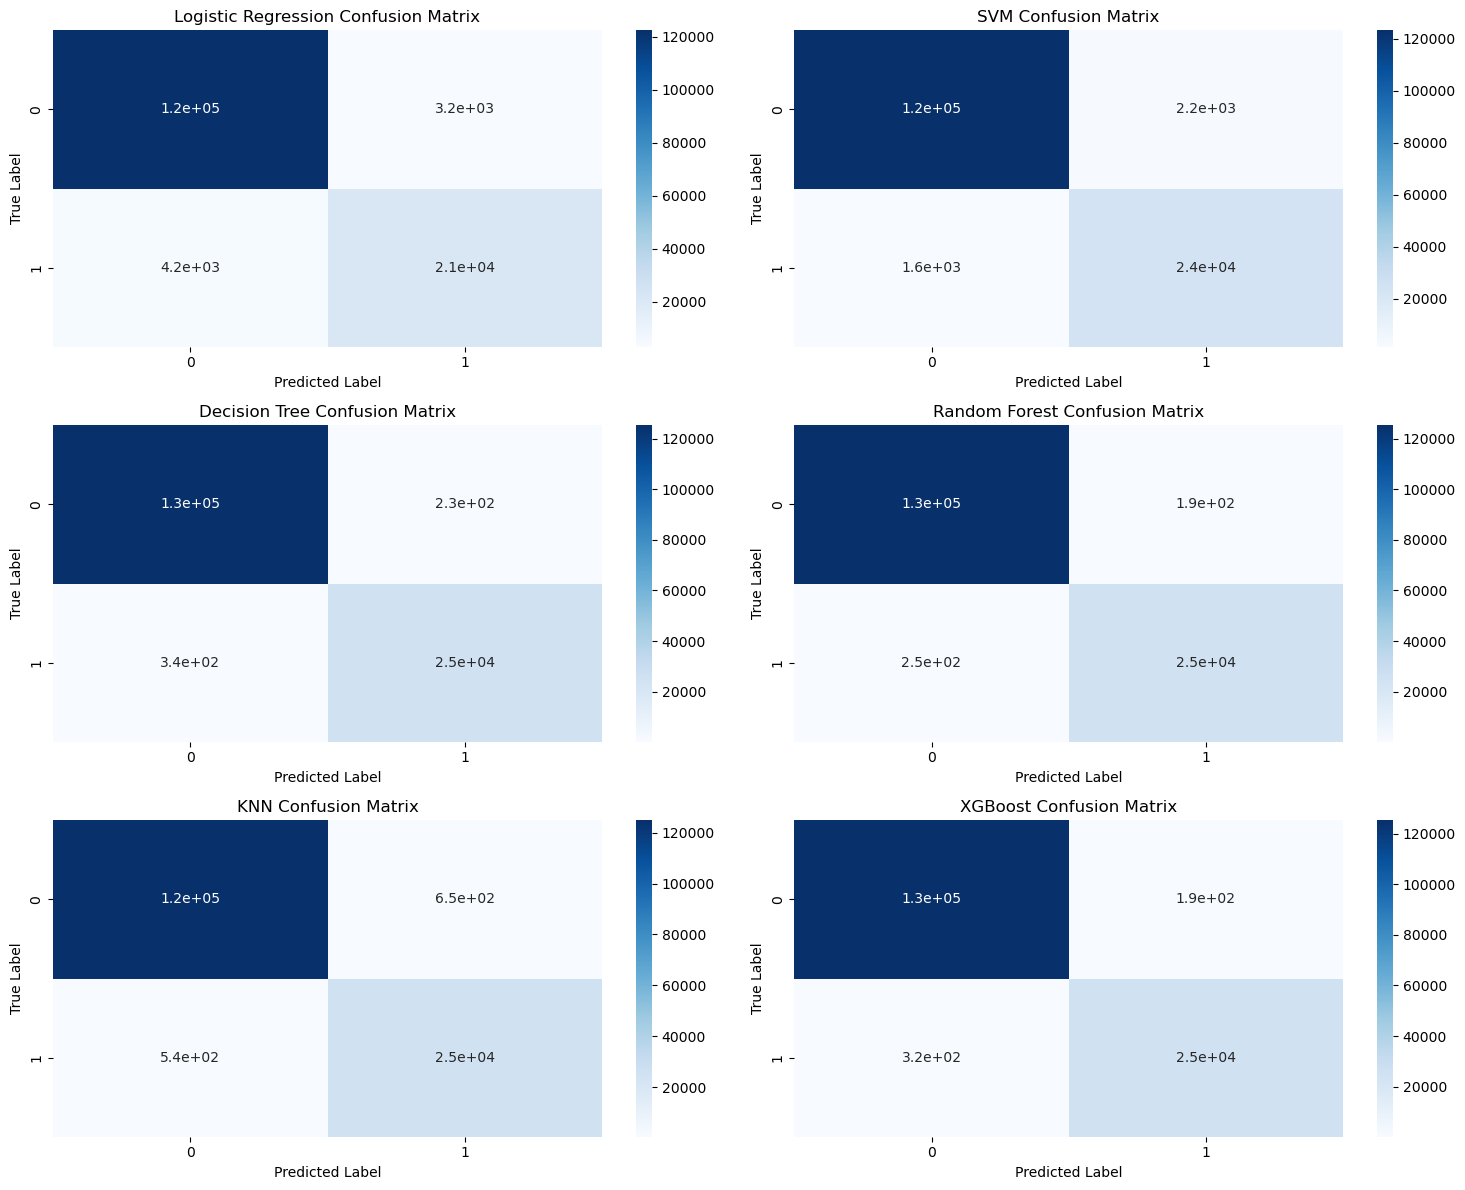

In [159]:
# Assuming you have the best models for each method stored in variables

models = [best_lr, best_svm, best_dt, best_rf, best_knn, best_xgb]  # Replace with your best models
model_names = ["Logistic Regression", "SVM", "Decision Tree", "Random Forest", "KNN", "XGBoost"]

fig, axes = plt.subplots(3, 2, figsize=(15, 12))  # Create a 3x2 subplot grid

# Loop through models and plot confusion matrices
for i, (model, name) in enumerate(zip(models, model_names)):
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)

    sns.heatmap(conf_matrix, annot=True, cmap='Blues', ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f'{name} Confusion Matrix')
    axes[i // 2, i % 2].set_xlabel('Predicted Label')
    axes[i // 2, i % 2].set_ylabel('True Label')

plt.tight_layout()
plt.show()

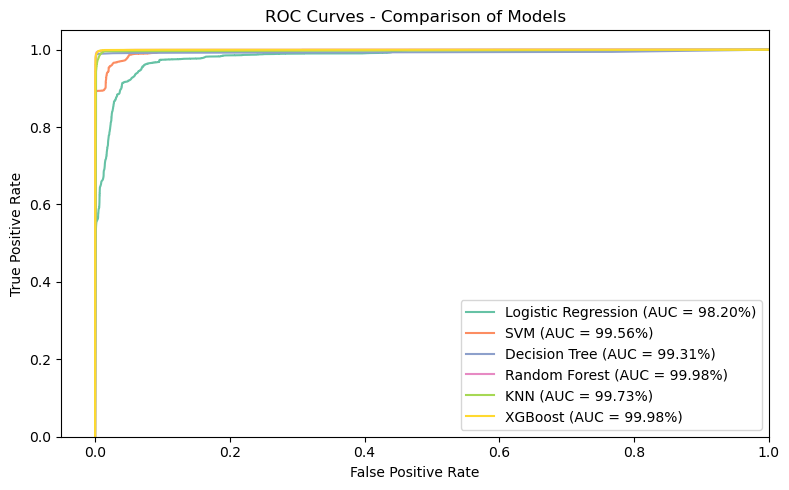

In [174]:
# Assuming you have the best models for each method stored in variables

models = [best_lr, best_svm, best_dt, best_rf, best_knn, best_xgb]  # Replace with your best models
model_names = ["Logistic Regression", "SVM", "Decision Tree", "Random Forest", "KNN", "XGBoost"]
colors = sns.color_palette('Set2', n_colors=len(models))  # Use a distinct color for each model

plt.figure(figsize=(8, 5))  # Create a single figure

for i, (model, name, color) in enumerate(zip(models, model_names, colors)):
  y_prob = model.predict_proba(X_test)[:, 1]  # Assuming binary classification
  fpr, tpr, _ = roc_curve(y_test, y_prob)
  roc_auc = auc(fpr, tpr)

  # Plot ROC curve for each model
  plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2%})', color=color)

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Comparison of Models')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

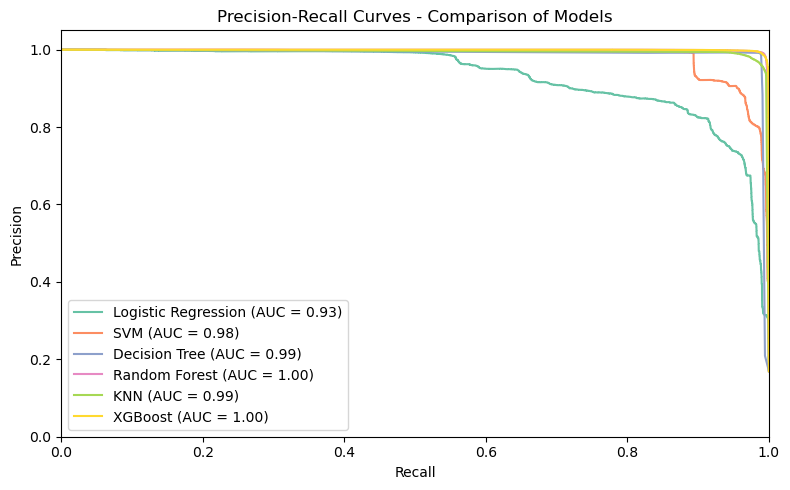

In [176]:
# Assuming you have the best models for each method stored in variables

models = [best_lr, best_svm, best_dt, best_rf, best_knn, best_xgb]  # Replace with your best models
model_names = ["Logistic Regression", "SVM", "Decision Tree", "Random Forest", "KNN", "XGBoost"]
colors = sns.color_palette('Set2', n_colors=len(models))  # Use a distinct color for each model

plt.figure(figsize=(8, 5))  # Create a single figure

for i, (model, name, color) in enumerate(zip(models, model_names, colors)):
  y_prob = model.predict_proba(X_test)[:, 1]  # Assuming binary classification
  precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
  roc_auc = auc(recall, precision)  # Calculate PR AUC

  # Plot PR curve for each model
  plt.plot(recall, precision, label=f'{name} (AUC = {roc_auc:.2f})', color=color)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves - Comparison of Models')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

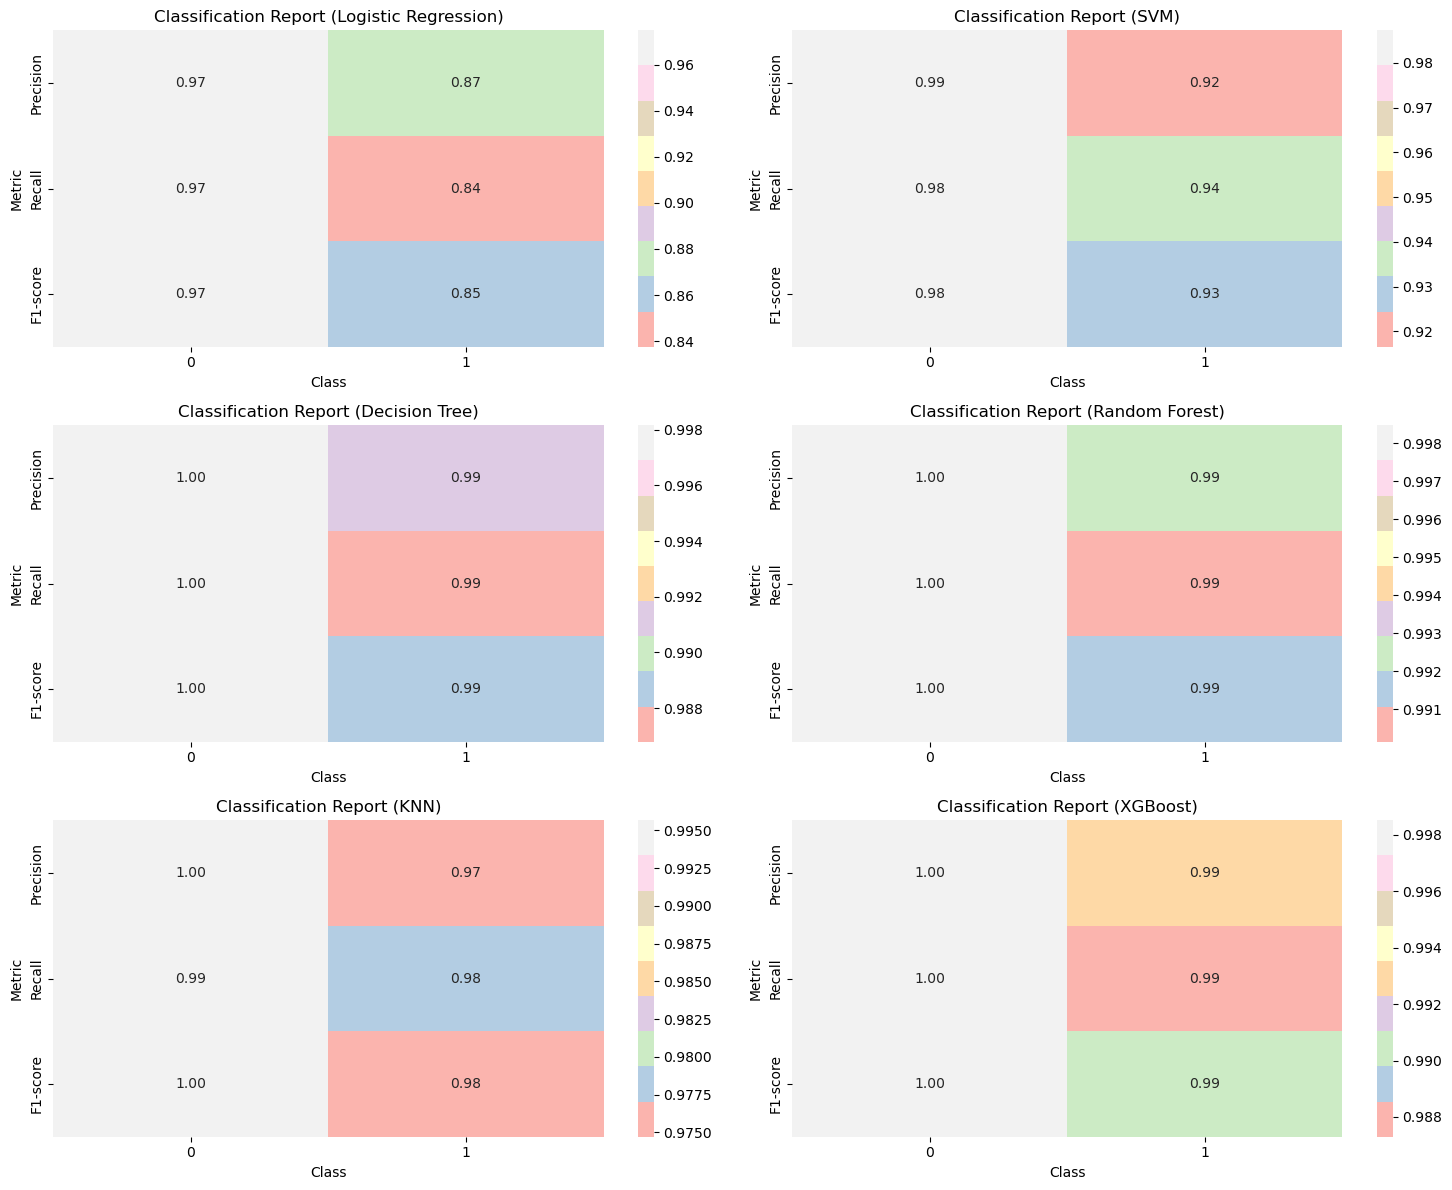

In [180]:
# Assuming you have the best models for each method stored in variables

models = [best_lr, best_svm, best_dt, best_rf, best_knn, best_xgb]  # Replace with your best models
model_names = ["Logistic Regression", "SVM", "Decision Tree", "Random Forest", "KNN", "XGBoost"]

fig, axes = plt.subplots(3, 2, figsize=(15, 12))  # Create a 3x2 subplot grid

for i, (model, name, ax) in enumerate(zip(models, model_names, axes.flat)):
  y_pred = model.predict(X_test)
  target_names = model.classes_

  metrics = classification_report(y_true=y_test, y_pred=y_pred,
                                 target_names=target_names, output_dict=True)

  precision = [metrics[target_name]['precision'] for target_name in target_names]
  recall = [metrics[target_name]['recall'] for target_name in target_names]
  f1_score = [metrics[target_name]['f1-score'] for target_name in target_names]

  data = np.array([precision, recall, f1_score])
  rows = ['Precision', 'Recall', 'F1-score']

  sns.heatmap(data, cmap='Pastel1', annot=True, fmt='.2f', xticklabels=target_names,
              yticklabels=rows, ax=ax)
  ax.set_title(f'Classification Report ({name})')
  ax.set_xlabel('Class')
  ax.set_ylabel('Metric')

plt.tight_layout()
plt.show()

In [ ]:
import mlflow
import mlflow.sklearn
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

# Train and log models using MLflow
def train_and_log_model(model, param_grid, model_name, X_train, y_train, X_test, y_test):
    with mlflow.start_run(run_name=f"{model_name}_GridSearch"):
        # Grid Search
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring='accuracy',
            cv=5,
            verbose=2,
            n_jobs=-1
        )
        
        # Train the model
        grid_search.fit(X_train, y_train)
        
        # Best parameters and score
        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_
        best_score = grid_search.best_score_
        print(f"\n{model_name}: Best Hyperparameters: {best_params}")
        print(f"{model_name}: Best Cross-validation Score: {best_score:.2f}")
        
        # Log parameters and metrics
        mlflow.log_params(best_params)
        mlflow.log_metric("best_cv_score", best_score)
        
        # Evaluate on test data
        y_pred = best_model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("test_accuracy", test_accuracy)
        print(f"{model_name}: Test Accuracy: {test_accuracy:.2f}")
        
        # Log the model
        mlflow.sklearn.log_model(best_model, f"{model_name}_model")
        print(f"{model_name} model logged in MLflow.")

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 1. SVM
svm_model = SVC()
svm_param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}
train_and_log_model(svm_model, svm_param_grid, "SVM", X_train, y_train, X_test, y_test)

# 2. Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}
train_and_log_model(dt_model, dt_param_grid, "DecisionTree", X_train, y_train, X_test, y_test)

# 3. Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
train_and_log_model(rf_model, rf_param_grid, "RandomForest", X_train, y_train, X_test, y_test)

# 4. XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
train_and_log_model(xgb_model, xgb_param_grid, "XGBoost", X_train, y_train, X_test, y_test)


In [ ]:
dagshub_token = "8b3b28ba1c406e613661a4ea795600bcefd3ecf3"

In [186]:
best_xgb.save_model("Xgboost_tuned.bin")

C:\Users\Dyari Elkamel\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [20:29:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
